In [1]:
# change the version of tensorflow (default is 2.x)
%tensorflow_version 1.x

Learning_rate = 0.001
Spliting_precentage = 0.1 
Batch_size = 256  # *= Aug_out  **********
Num_epochs = 30
Time_steps = 20


# may be he need to see more from the image to capture the speed information 
inputH = 100
inputW = 320
inputC = 3


# Agumentation 
angle_shift = {
    'center':0 ,
    'left':0.25 ,
    'right':-0.25
}

Salt_Precentage = 0.015
Peper_Precentage = 0.030
drop_out_region_precentage = 0.1

H_angle_shift = 0.0035 
H_shift_low  = -60
H_shift_high = 61

CNN_reg_val = 0
FC_reg_val = 0
FC_drop_val = 0.5

Aug_out = 12

Train_file_name = "my_data9/driving_log.csv"
Valid_file_name =  "data/driving_log.csv"
N_file_name =  "hard/driving_log.csv"

Model_name = "Multi_model_model.h5"
Data_link = 'https://s3.amazonaws.com/video.udacity-data.com/topher/2016/December/584f6edd_data/data.zip'

TensorFlow 1.x selected.


In [0]:
#imports 
import matplotlib.pyplot as plt
import pickle

In [0]:
#Utils 

# custom call backs 

import tensorflow as tf 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import keras 
import os 
class MyCustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self , epoch , logs=None):
          name = 'FMulti_model'
          if not os.path.isfile(name+'.h5'):
              print("file is not exist :{}".format(name))
              return

          print("saving model" , name +'.h5' , '.............')
          auth.authenticate_user()
          gauth = GoogleAuth()
          gauth.credentials = GoogleCredentials.get_application_default()
          drive = GoogleDrive(gauth)

          # 2. Save Keras Model or weights on google drive
          # create on Colab directory
          save_name = name + "_" + str(epoch) + "_605_" +'.h5'
          file_name = name + '.h5'

          model_file = drive.CreateFile({'title' : save_name})
          model_file.SetContentString(file_name) # was the issue 
          model_file.Upload()
          print("successfull saved to drive at {}".format("ahmedaraby605@gmail.com"))
          return

# freeze model layers 
def freeze(model):
    model_layers = []
    model_layers.append(model.get_layer('angle_out'))
    model_layers.append(model.get_layer('anglefc1'))
    model_layers.append(model.get_layer('anglefc2'))
    model_layers.append(model.get_layer('anglefc3'))

    model_layers.append(model.get_layer('cnn1'))
    model_layers.append(model.get_layer('cnn2'))
    model_layers.append(model.get_layer('cnn3'))
    model_layers.append(model.get_layer('cnn4'))
    model_layers.append(model.get_layer('cnn5'))

    for layer in model_layers:
      print(layer)
      # by reference
      layer.trainable = False
    return 

def save_file(X , name):
    with open(name , 'wb') as f:
      pickle.dump(X , f)
    return 
    
def download_unzip_data():
    # download the data 
    from urllib.request import urlretrieve
    import os
    def download(url, file):
        if not os.path.isfile(file):
            print("D  ownload file... " + file + " ...")
            urlretrieve(url,file)
            print("File downloaded")

    print("All the files are downloaded")
    download(Data_link, 'data.zip')

    # extract the data 
    !unzip "data.zip"
    !unrar x "/content/drive/My Drive/my_data9.rar"
    

# mountain drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

download_unzip_data()

# test 
obj = MyCustomCallback()
obj.on_epoch_end(1)



In [0]:
# Preprocessing 

import numpy as np
import cv2

def edit_path(img_path):
    """
    this function do no't give shit about img type 
    """
    img_path = img_path.strip()
    ls=img_path.split('/')
    
    if img_path[0]=='C':
        ls = img_path.split('\\')
      


    if len(ls) ==2:
        img_path = "data/" + img_path
    elif len(ls) == 7:
        if(img_path[0]=='C'):
            img_path = 'my_data9'
        else:
            img_path = 'hard'
        for i in range(5, len(ls), 1):
            img_path = img_path +'/'+ ls[i]
    else:
      assert("un recognized type ")
    #print(img_path)
    return img_path

def read_img(img_path):
    """
    - train the model on RGB image,
      as the simulator produce RGB image
    """
    img_path = edit_path(img_path)
    img = cv2.imread(img_path, -1)  # BGR
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)  # RGB
    return img

def resize_img(img , tH=inputH , tW=inputW):
    img = cv2.resize(img ,  (tW, tH))  # order of parameters, right  !??
    return img

def crop_img(img):
    H , W , _ = img.shape
    img = img[40:H-20, :, :]
    return img

def normalize_img_0_1(img):
  img = img /255.0
  img = img.astype(np.float32) # less memory
  return img

def preprocessing_pipeline(img):
    img = normalize_img_0_1(img)
    #img = resize_img(img) 
    img = crop_img(img)
    return img

 

In [0]:
# Agumentation 

import numpy as np
import cv2


# angle 

def edit_angle(angle , camera):
    angle = angle + angle_shift[camera]
    return angle

def flip_angle(angle):
    # aid the horizontal_flip function
    return - angle

def h_angle_shift(angle, shifted_pixels):

    shifted_angle = angle + shifted_pixels * H_angle_shift
    if shifted_angle<-1:
        shifted_angle=-1
    elif shifted_angle >1:
        shifted_angle=1
    return shifted_angle

# image

def flip_img(img):
    """
    :param img:  rgb , float [0 , 1]
    """
    img = cv2.flip(img, 1) # horizontal
    return img

def darken(img , l_dark = 0.4 , h_dark = 0.75):
    """
    - need image to be normalized [0 , 1] , why?!
    """
    scaler = np.random.uniform(low=l_dark , high=h_dark)
    img = img * scaler
    return img

# add noise 
def build_salt_peper_mat():
    """
      pixels that have salt in it 
      will not have peper 
    
      pixels that have peper in it 
      will not have slat 
    
      so they will not affect each other 
    """

    peper_mat = np.ones(shape=[inputH, inputW, 1])  # multiply
    salt_mat  = np.zeros(shape=[inputH, inputW, 1])  # add

    for i in range(0 , inputH , 1):
        for j in range(0 , inputW , 1):
            rand = np.random.rand()
            if rand <= Salt_Precentage:
                salt_mat[i][j][0]=1
            elif rand <= Peper_Precentage:
                peper_mat[i][j][0]=0

    return peper_mat, salt_mat

def add_salt_peper_noise(img ,peper_mat, salt_mat):
    # add peper
    new_img= img * peper_mat
    # add salt
    new_img = new_img + salt_mat
    # clip the value out from the boundries
    new_img = np.clip(new_img , a_min=0 , a_max=1)
    return new_img

def add_shadows(img,l_shadow = 0.5, h_shadow = 0.85):
    """
    :param img: have to be normalized [0 to 1]
    - currently the shadows will cover all the V dimension,
        but the H dim will be random
    """

    """
    # image coordinates in open cv  (Y , X)
    # indexing = (row , col , channels) , shape = (height , width , channels)
    # functions take arguments in (col , row)   
    #    _ _ _ _ _ _  (X)
    #   |
    #   |
    #   |
    #   |
    #  (Y)
    """
    
    inputH , inputW , _ = img.shape
    shadow_scaler = np.random.uniform(low=l_shadow , high=h_shadow)

    # get the points
    # upper part
    # left
    upper_left_Y  = 0
    upper_left_X  = np.random.randint(low=0 , high=inputW//2)
    # right
    upper_right_Y = 0
    upper_right_X = np.random.uniform(low=inputW//2+1 , high=inputW-1)

    # lower part
    # right
    lower_right_Y = inputH-1
    lower_right_X = np.random.uniform(low=inputW//2+1 , high=inputW-1)
    # left
    lower_left_Y = inputH-1
    lower_left_X = np.random.uniform(low=0 , high=inputW//2)

    # order of points matters as polyfill just c onnect the points (col , row)
    points = [[upper_left_X, upper_left_Y],
              [upper_right_X, upper_right_Y],
              [lower_right_X, lower_right_Y],
              [lower_left_X, lower_left_Y]]
    mask = np.ones(img.shape)
    cv2.fillPoly(mask, np.array([points], dtype=np.int32), [shadow_scaler, shadow_scaler, shadow_scaler])

    img = img * mask
    return img


def h_shift_img(img , l_shift=H_shift_low , h_shift=H_shift_high):
    h_shift_val = np.random.uniform(low=l_shift , high=h_shift)
    v_shift_val = 0
    hight , width  , _ = img.shape
    Mat = np.array([[1 , 0 , h_shift_val],
                    [0 , 1 , v_shift_val]] , dtype=np.float32)
    img = cv2.warpAffine(img , Mat , dsize=(width , hight))
    return img , h_shift_val
    
def vertical_shift(img, L_verticle_shift=-50, H_verticle_shift=-20):
    assert ("will have no use as we crop the image")

def agumentation_pipeline(img , original_angle , camera, apply_agum, peper_mat , salt_mat):
    """
    :param img:  color: RGB, data_type: float range(0 , 1)
    """
    images = []

    # original image , calibrate the angle if needed
    original_angle = edit_angle(original_angle , camera)
    images.append((img , original_angle))

    # case of validation data
    if apply_agum==False:
        return images

    # darken the image
    dark_img = darken(img)
    images.append((dark_img , original_angle))

    # add shadows
    shadow_img = add_shadows(img)
    images.append((shadow_img , original_angle))

    # add noise 
    noisey_img = add_salt_peper_noise(img , peper_mat , salt_mat)
    
    """
    # flip image
    # as the car is always in the right side of the rood 
    #but it may be good for avoiding overfitting 
    if camera=='center': 
      Hflip_angle = flip_angle(original_angle)
      Hflip_img = flip_img(img)
      images.append((Hflip_img, Hflip_angle))

    # horizontal shift 
    shifted_img , shift_amount = h_shift_img(img)
    new_angle = h_angle_shift(original_angle , shift_amount)
    images.append((shifted_img , new_angle))
    
    """
    
    return images 



In [0]:
# Loading the Data 

import numpy as np
import pandas as pd
import cv2

def load_data(file_name , file_type):
    if file_type=='data':
        Data = pd.read_csv(file_name)
    elif file_type=='hard':
        Data = pd.read_csv(file_name, header=None)
        Data.columns = ['center' , 'left' , 'right' , 'steering' , 'throttle' , 'brake' , 'speed']

    print("size of data set is : " , Data.shape)
    data_set_length = Data.shape[0]

    Left_camera = []
    Center_camera = []
    Right_camera = []
    Angle = []
    Throttle = []
    Brake = []
    Speed = []

    for i in range(0 , data_set_length , 1):
        angle = Data['steering'][i]
        Left_camera.append(Data['left'][i])
        Center_camera.append(Data['center'][i])
        Right_camera.append(Data['right'][i])
        Angle.append(Data['steering'][i])
        Throttle.append(Data['throttle'][i])
        Brake.append(Data['brake'][i])
        Speed.append(Data['speed'][i])

    Left_camera = np.array(Left_camera).reshape(-1 , 1)
    Right_camera  = np.array(Right_camera).reshape(-1 , 1)
    Center_camera = np.array(Center_camera).reshape(-1, 1)
    Angle = np.array(Angle).reshape(-1 , 1)
    Throttle = np.array(Throttle).reshape(-1 , 1)
    Brake = np.array(Brake).reshape(-1 , 1)
    Speed = np.array(Speed).reshape(-1 , 1)

    return (Left_camera , Center_camera , Right_camera) , Angle, Speed

def build_sequence(camera , angle , speed, time_steps):
    """
    - Data order still been kept here.
    build the input speed sequence
    build the output speed corresponding to each sequence
    """

    leftC , centerC , rightC = camera
    
    # discard the images and data with no complete sequence
    leftC   = leftC[time_steps:]
    centerC = centerC[time_steps:]
    rightC  = rightC[time_steps:]
    angle = angle[time_steps:]

    # sample the speed
    for i in range(0, speed.shape[0], 1):
        speed[i] = sample_speed(speed[i])
    # plot the speed distribution 
    
    plt.hist(speed, bins = 30)  
    plt.xlabel("speed value")
    plt.ylabel("frequency")
    plt.title("speed analysis")
    plt.show()

    data_set_length = speed.shape[0] - time_steps
    input_speed  = np.zeros(shape=[data_set_length, time_steps , 1]) # standard input for LSTM
    Y_speed = np.zeros(shape=[data_set_length , 1])

    for i in range(time_steps, speed.shape[0]):
        # i is the Y value for the lstm
        # i - time steps is the beginning of the sequence

        # build the input
        sequence = speed[i-time_steps:i]
        input_speed[i-time_steps, : , :] = sequence
        Y_speed[i-time_steps] = speed[i]

    return (leftC , centerC ,rightC) , angle , input_speed , Y_speed


def shuffle(camera, angle,  input_speed, Y_speed):
    """
    shuffle sequences of the data
    """
    np.random.seed(1) # keep same order for each shuffle to aid the model in non continuous training 

    index = np.random.permutation(angle.shape[0])
    leftC , centerC , rightC = camera

    # inputs
    leftC = leftC[index]
    centerC = centerC[index]
    rightC = rightC[index]
    input_speed = input_speed[index]

    # outputs
    angle = angle[index]
    Y_speed = Y_speed[index]

    #print("shuffling is done")
    return (leftC , centerC , rightC) , angle , input_speed , Y_speed


def sample_speed(speed):
    sp = speed
    if sp >=5 and sp<=10:
        sp = 10
    elif sp >10 and sp <22:
        sp = 15
    # else leave it as it's 
    speed = sp
    return speed

def get_loss_weights(angle):
    """
    - Data with straight forward angle will have small loss as it appear a lot in
      the data set !!! , is there any other reason ????
      does the sum of the losses for the different functions have to be summed to 1 !?
    """
    assert("not implemented yet")

def generate_batch(camera, angle, input_speed, Y_speed, apply_agum , img_type , batch_size):
    """
        my own generators , will be passed to fit_generator
        to handle data sets with big size
        drawback: if the data set size % batch size !=0
        the model will bring data from the beginning of the data set (been processed twice )
    """

    data_set_length = angle.shape[0]
    leftC , centerC , rightC = camera
    in_speed_batch  = []  
    out_speed_batch = [] 
    out_angle_batch = [] 
    in_image_batch  = []
    
    peper_mat , salt_mat = build_salt_peper_mat()

    index = 0
    while True:
        
        original_angle = angle[index][0]

        # don't change with the agumentation I do.
        speed_sequence = input_speed[index]    #  ********************  bug *************************
        current_speed = Y_speed[index][0]
        
        # normalizing 
        speed_sequence = speed_sequence  / 30.19
        current_speed = current_speed  / 30.19

        cams = 0
        came = 3
        if img_type == 'valid':  # just get the center 
            cams = 1
            came = 2
        ###### bug was in assigning the type of the camera  center and left and I guess this illustrate why it go more to right ######
        for cam in range(cams , came):
            camera = ""
            if cam==0: # left
                image_path  = leftC[index][0]
                camera='left'
            elif cam==1: # center
                image_path  = centerC[index][0]
                camera = 'center'
            else: # right
                image_path  = rightC[index][0]
                camera = 'right'
            
            img = read_img(image_path)
            img = preprocessing_pipeline(img)
            images = agumentation_pipeline (img , original_angle, camera, apply_agum, peper_mat , salt_mat)
            
            for img , new_angle in images:
                in_image_batch.append(img)
                out_angle_batch.append(new_angle)
                
                in_speed_batch.append(speed_sequence)
                out_speed_batch.append(current_speed)

        index = (index +1)  % angle.shape[0]
        if len(in_image_batch) >= batch_size:
            # get new noise matrices as this will increase the randomness
            peper_mat , salt_mat = build_salt_peper_mat()

            # reshape 
            __in_image_batch  =  np.array(in_image_batch).reshape(-1 , inputH, inputW , 3)
            __in_speed_batch  =  np.array(in_speed_batch).reshape(-1, Time_steps, 1)
            __out_angle_bacth =  np.array(out_angle_batch).reshape(-1 , 1)
            __out_speed_batch =  np.array(out_speed_batch).reshape(-1 , 1)

            in_image_batch  = []
            in_speed_batch  = []
            out_angle_batch = []
            out_speed_batch = []

            inputs =[__in_image_batch , __in_speed_batch]
            outputs = [__out_angle_bacth , __out_speed_batch]
            #print("batch size   " , __in_image_batch.shape[0])
            yield (inputs, outputs)
    return

def get_data(file_name , file_type):
    camera, angle, speed = load_data(file_name , file_type)
    camera, angle, input_speed, Y_speed = build_sequence(camera, angle, speed, Time_steps)
    #camera, angle, input_speed, Y_speed = shuffle(camera, angle, input_speed, Y_speed)
    return camera, angle, input_speed,Y_speed

def conc(X ,Y):
    X = np.row_stack((X , Y))
    return X


In [0]:
from keras.layers import Dense , LSTM , concatenate , Input
from keras.layers import  Conv2D , MaxPool2D , Flatten , ZeroPadding2D
from keras.optimizers import SGD , Adam
from keras.utils import plot_model
from keras import Model
from keras.initializers import glorot_uniform, he_uniform
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l2
from keras.layers import Dropout
import math


def get_speed_out(speed_input , shared_layer):
    
    init = glorot_uniform()
    LSTM_layer = LSTM(128, activation='tanh', return_sequences=False, init = init)(speed_input)
    
    FC_layer = Dense(50, activation='relu' , init = init, kernel_regularizer = l2(FC_reg_val))(LSTM_layer)

    FC_layer = Dense(50, activation='relu' , init = init, kernel_regularizer = l2(FC_reg_val))(FC_layer)

    # concatenate the input from the shared layer
    merged_input = concatenate(inputs=[FC_layer , shared_layer])

    FC_layer = Dense(50 , activation='relu' , init = init,  kernel_regularizer = l2(FC_reg_val))(merged_input)
    
    # *************** regression layer ******************
    speed_out = Dense(1 , name='speed_out', init = init,   kernel_regularizer = l2(FC_reg_val))(FC_layer)

    return speed_out

def Multi_task_Multi_output_Model(inputH, inputW, inputC, time_steps):
    init = glorot_uniform()
  
    image_input = Input(shape=(inputH ,inputW , inputC))
    speed_input = Input(shape=(time_steps,1))

    # CNN layers
    # first layer
    padded_img = ZeroPadding2D((2 , 2))(image_input)
    CNN_layer = Conv2D(96, (11 , 11),strides=[2 , 2],
                       init = init, name='cnn1')(padded_img)
    batch_norm_layer = BatchNormalization()(CNN_layer)  
    activ_layer = Activation('relu')(batch_norm_layer)
    max_pool = MaxPool2D((3 , 3),strides=[2 , 2])(activ_layer)
    
  
    # second layer
    CNN_layer = Conv2D(256 , (5 , 5), padding='same',
                       init = init, name='cnn2')(max_pool)
    batch_norm_layer = BatchNormalization()(CNN_layer) 
    activ_layer = Activation('relu')(batch_norm_layer)
    max_pool = MaxPool2D((3 , 3) , strides=[2 , 2])(activ_layer)

    # third layer
    CNN_layer = Conv2D(384, (3 , 3), strides=[2, 2],
                       init = init, name='cnn3')(max_pool) 
    activ_layer = Activation('relu')(CNN_layer)                   

    # forth layer
    CNN_layer = Conv2D(384, (3 , 3), padding='same',
                       init = init, name='cnn4')(activ_layer) 
    activ_layer = Activation('relu')(CNN_layer)

    # fifth layer
    CNN_layer = Conv2D(256, (3 , 3),
                       init= init, name='cnn5')(activ_layer) 
    activ_layer = Activation('relu')(CNN_layer)

    # fully connected layers
    Flatten_layer = Flatten()(activ_layer)

    # FC1
    FC_layer = Dense(1024, activation='relu' , init = init ,kernel_regularizer = l2(FC_reg_val), name='anglefc1')(Flatten_layer) 
    
    # FC2 and shared layer between the 2 models
    shared_layer = Dense(50, activation='relu' , init = init,kernel_regularizer = l2(FC_reg_val), name='anglefc2')(FC_layer)

    ################################################
    # send it to the speed model to be concatenated
    speed_out = get_speed_out(speed_input, shared_layer)
    ################################################
    
    
    # FC3
    FC_layer = Dense(50, activation='relu' , init = init,kernel_regularizer = l2(FC_reg_val), name='anglefc3')(shared_layer)

    # steering angle prediction it's regression (continuous) value
    angle_out = Dense(1 , name='angle_out', init = init, kernel_regularizer = l2(FC_reg_val))(FC_layer)
    #############################################################
  
    model = Model(inputs=[image_input , speed_input] , outputs=[angle_out , speed_out])
    opt = Adam(lr = Learning_rate)
    model.compile(optimizer=opt , loss=['mse', 'mse'], loss_weights=[1, 1])
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model




start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (11, 11), strides=[2, 2], name="cnn1", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), padding="same", name="cnn2", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(384, (3, 3), strides=[2, 2], name="cnn3", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(384, (3, 3), padding="same", name="cnn4", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="cnn5", kerne

size of data set is :  (78943, 7)


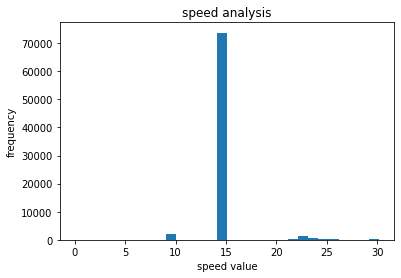

train angle  (71030, 1)
train input speed  (71030, 20, 1)
validation angle  (7893, 1)
validation input speed  (7893, 20, 1)

Epoch 1/30
3330/3330 [==============================] - 1476s 443ms/step - loss: 0.4575 - angle_out_loss: 0.0937 - speed_out_loss: 0.3638 - val_loss: 0.0915 - val_angle_out_loss: 0.0873 - val_speed_out_loss: 4.9859e-04
saving model FMulti_model.h5 .............
successfull saved to drive at ahmedaraby605@gmail.com
Epoch 2/30
3330/3330 [==============================] - 1442s 433ms/step - loss: 0.0820 - angle_out_loss: 0.0814 - speed_out_loss: 6.0157e-04 - val_loss: 0.0856 - val_angle_out_loss: 0.0815 - val_speed_out_loss: 4.4605e-04
saving model FMulti_model.h5 .............
successfull saved to drive at ahmedaraby605@gmail.com
Epoch 3/30
1565/3330 [=============>................] - ETA: 12:54 - loss: 0.0803 - angle_out_loss: 0.0797 - speed_out_loss: 5.9741e-04

In [0]:
 # training
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models  import load_model
from keras.callbacks import LambdaCallback

def train_model():
    model = Multi_task_Multi_output_Model(inputH, inputW, inputC, Time_steps)

    # Data 
    T_camera, T_angle, T_input_speed,T_Y_speed = get_data(Train_file_name , 'hard')

    # unpack
    T_leftC, T_centerC, T_rightC = T_camera
    
    # split
    T_leftC , V_leftC , T_centerC , V_centerC , T_rightC , V_rightC , T_angle , V_angle \
    , T_input_speed , V_input_speed, T_Y_speed , V_Y_speed = train_test_split(T_leftC , T_centerC , T_rightC , T_angle \
                                                                              , T_input_speed , T_Y_speed , test_size = Spliting_precentage , random_state=2)
    # pack 
    T_camera = (T_leftC, T_centerC, T_rightC)
    V_camera = (V_leftC, V_centerC, V_rightC)

    T_steps_per_epoch = math.ceil( (T_angle.shape[0] * Aug_out)/ Batch_size)
    V_steps_per_epoch = math.ceil(V_angle.shape[0]  / Batch_size)

    print("train angle ", T_angle.shape)
    print("train input speed ", T_input_speed.shape)

    print("validation angle ", V_angle.shape)
    print("validation input speed ",V_input_speed.shape)

    train_generator = generate_batch(T_camera , T_angle , T_input_speed , T_Y_speed , True , 'train' ,  Batch_size)
    valid_generator = generate_batch(V_camera , V_angle , V_input_speed , V_Y_speed , False , 'valid' ,  Batch_size)

    #test_model_feed(valid_generator)

    best_model = ModelCheckpoint('BMulti_model.h5', monitor='val_loss' , save_best_only=True)
    frequent_model = ModelCheckpoint('FMulti_model.h5', monitor='val_loss' , save_best_only=False)
    frequent_weights = ModelCheckpoint('BMulti_model_weights.h5', monitor='val_loss' , save_weights_only=True, save_best_only=True)

    model.fit_generator(train_generator,
                        steps_per_epoch = T_steps_per_epoch,
                        validation_data = valid_generator,
                        validation_steps = V_steps_per_epoch,
                        verbose = 1,
                        epochs=Num_epochs,
                        callbacks = [best_model , frequent_model, frequent_weights, MyCustomCallback()])
    
    # plot the results 
    visualize_training_history(history.history)
    save_file(history.history, 'history.pickle')

    model.save_weights("final_multi_model_weights.h5")
    model.save(Model_name)

print("start")
train_model()
print("end")

In [0]:
import matplotlib.pyplot as plt
def test_model_feed(generator):
  batch = generator.__next__()
  inp = batch[0]
  out = batch[1]

  images = inp[0]
  angle = out[0]
  print(images.shape)
  plt.imshow(images[127])
  print(angle[127])


  def visualize_training_history(history):
    """with open("history.pickle", 'rb') as f:
      history = pickle.load(f)"""
      
    fig1 = plt.figure(1)
    plt.plot(history['angle_out_loss'])
    plt.plot(history['val_angle_out_loss'])
    fig2 = plt.figure(2)
    plt.show()

    fig2 = plt.figure(2)
    plt.plot(history['speed_out_loss'])
    plt.plot(history['val_speed_out_loss'])
    plt.legend(['speed',  'val_speed'])

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("train , val accuracy ")
    plt.show()

  


In [9]:
"""
new settigns :
1 - tanh 
2 - not regularization 
3 - all augmentation 
4 - no pretraining 
5 - only track2 
6 - speed sampling trick
7 - learning rate = 0.001
"""

'\nnew settigns :\n1 - tanh \n2 - not regularization \n3 - all augmentation \n4 - no pretraining \n5 - only track2 \n6 - speed sampling trick\n7 - learning rate = 0.001\n'